# Bandits from Logged Data 

- M. Dudik J. Langford, and L. Li, "[Doubly Robust Policy Evaluation and Learning](https://arxiv.org/abs/1103.4601)" (2017).
- A. Swaminathan and T. Joachims, "[The Self-Normalized Estimator for Counterfactual Learning](https://www.microsoft.com/en-us/research/publication/self-normalized-estimator-counterfactual-learning/)" (2015).
- A. Beygelzimer and J. Langford, "[The Offset Tree for Learning with Partial Labels](https://arxiv.org/abs/0812.4044)" (2008).

## Turning a classification task into a bandit problem

This section follows "Doubly Robust Policy Evaluation and Learning".

Assume a dataset with features $x$ and class $c$. This dataset can be turned into a bandit problem. The actions are $a(x)$ are to select a the class for instance $x$. The Reward is $1$, when the correct class is selected and $0$ otherwise. 

To build an off-policy dataset, fit a classifactor on a subset of the dataset and use the predicted class probability as a policy. I.e., if the classificator preditcs $\hat{p}(c|x)$, select action $a(x) = c$  with proability $\hat{p}(c|x)$.

For the [census dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld), this transformation is implemented in `chmp.app.causality.dataset.census`. It contains the following additional columns:

- `value_mean`: a scalar reward, that depends the correctness of the choice and on the true class.
- `value`: `value_mean` with additional Gaussian nose.

In [1]:
%matplotlib inline

In [483]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.ensemble
import sklearn.metrics

In [3]:
from chmp.ds import shuffled

In [487]:
n_samples = 2_000
base_x, y = sklearn.datasets.make_classification(
    n_samples=n_samples, 
    n_features=10, 
    n_informative=2,
    n_repeated=2, 
    shuffle=False, 
    n_classes=2,
    n_clusters_per_class=2,
    random_state=21,
)

idx = shuffled(131_313, np.arange(n_samples))

base_x = base_x[idx].astype('float32')
y = y[idx].astype('int64')

In [501]:
est = sklearn.ensemble.GradientBoostingClassifier(n_estimators=20, learning_rate=0.02, random_state=32_032)
est.fit(base_x[:10], y[:10])

logging_policy = est.predict_proba(base_x)
logging_action = est.predict(base_x)
#logging_policy = 0.5 + 0.0 * logging_policy

print('accuracy {:.3}'.format((logging_action == y).mean()))
print('auc score {:.3}'.format(sklearn.metrics.roc_auc_score(y, logging_policy[:, 1])))

accuracy 0.646
auc score 0.91


In [502]:
action = np.random.binomial(n=1, p=logging_policy[:, 1], size=n_samples).astype('int64')
reward = (action == y).astype('float32')

p_action = logging_policy[np.arange(n_samples), action].astype('float32')

# include the action inside the features
x = np.concatenate((base_x, action[:, None]), axis=1)
x = x.astype('float32')

In [521]:
x_train = x[:1000]
y_train = {
    'propensity': p_action[:1000],
    'action': action[:1000], 
    'reward': reward[:1000], 
    'optimal_action': y[:1000],
}

x_test = x[1000:]
y_test = {
    'propensity': p_action[1000:],
    'action': action[1000:], 
    'reward': reward[1000:], 
    'optimal_action': y[1000:],
}

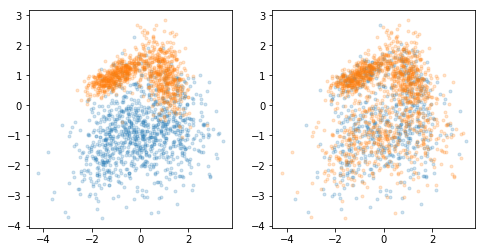

In [504]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax1)
plt.plot(x[y == 0, 0], x[y == 0, 1], '.', alpha=0.2)
plt.plot(x[y == 1, 0], x[y == 1, 1], '.', alpha=0.2)

plt.sca(ax2)
plt.plot(x[action == 0, 0], x[action == 0, 1], '.', alpha=0.2)
plt.plot(x[action == 1, 0], x[action == 1, 1], '.', alpha=0.2)

In [505]:
from chmp.ds import reload

In [506]:
import functools as ft

import numpy as np
import pandas as pd

reload('chmp.app.causality.dataset.census')
from chmp.app.causality.dataset.census import features, columns

import torch
import torch.nn.functional as F

from chmp.torch_utils.model import Model

In [507]:
#df = pd.read_parquet('data/census.parquet')

In [508]:
#p = np.asarray(df['action_p'], dtype='float32')
#a = np.asarray(df['action'], dtype='int64')
#r = np.asarray(df['value'], dtype='float32')

#x = np.asarray(pd.get_dummies(df[[*features, 'action']]), dtype='float32')
#y = (p, a, r)

In [509]:
n_samples, n_features = x_train.shape
n_classes = 2

In [510]:
print(f'{n_samples:,d} samples, {n_features} features')

1,000 samples, 11 features


Two problems:
    
- Policy optimization: optimize a policy based on historic observations
- Policy evalulation: given an existing policy evaluate the expected reward based on historic observations

Interactive vs. Non interactive

## Offset tree reduction

Basic idea: turn the bandit problem into a weighted-classificaiton problem. The predicted class is the optimal action. The classifier with the lowest classification error, will also be the optimial policy.

Problem description:
    
- $x$: features
- $a \in \{-1, +1\}$: action
- $r(a) \in [0, 1]$: reward for action $a$

Goal is to chose $\pi$ as to maximze:

$$
    \mathbb{E}_{x,a \sim \pi(a|x)} \left[ r(a) \right]
$$

Note: alternative view (hence the name partially labelled): all rewards are generated on-block, but only the reward for the chosen action is revealed.

Note for non-binary action spaces, decompose the action space to binary problems and apply the same technique.

## Inverse propensity estimator (IPS)

$$
\begin{aligned}
    \hat{V}^\pi_\mathrm{IPS} 
        &= \sum_{x,a,r_a,p_a} \frac{r_a \mathbb{1}(\pi(x) = a)}{p_a} 
\end{aligned}
$$

Turn it into a loss function

$$
\begin{aligned}
    \mathcal{L}_\mathrm{IPS}(\pi)
        &= \sum_{x,a,r_a,p_a} \frac{p^{\pi}(a|x)}{p_a} r_a 
\end{aligned}
$$

In [511]:
def ips_loss(p_model, truth):
    """The inverse propensity score loss"""
    p_new = (
        truth['action'].type(torch.float32) * p_model[:, 1] 
        + (1 - truth['action']).type(torch.float32) * p_model[:, 0]
    )
    weights = p_new / truth['propensity']
    
    return -(truth['reward'] * weights).mean()


def snips_loss(p_model, truth):
    """The Self-Normalized Estimator for Counterfactual Learning"""
    p_new = (
        truth['action'].type(torch.float32) * p_model[:, 1] 
        + (1 - truth['action']).type(torch.float32) * p_model[:, 0]
    )
    weights = p_new / truth['propensity']
    
    return -(truth['reward'] * weights).sum() / weights.sum()


def offset_tree_loss(p_model, truth):
    """Loss to learn according the binary offset-tree reduction.
    
    Based on A. Beygelzimer and J. Langford, "The Offset Tree 
    for Learning with Partial Labels" (2008).
    """
    
    weights = abs(truth['reward'] - 0.5) / truth['propensity']
    target = 0.5 * (1 + torch.sign((2 * truth['action'].type(torch.float32) - 1) * (truth['reward'] - 0.5)))
    nll = (1 - target) * torch.log(p_model[:, 0]) + target * torch.log(p_model[:, 1])
    return -(weights * nll).mean()
    

def true_reward(p_model, truth):
    action = p_model.argmax(dim=1)
    return (action == truth['optimal_action']).type(torch.float32).mean()

In [512]:
reload('chmp.torch_utils.model')
from chmp.torch_utils.model import Model

In [513]:
from distributed import Client, LocalCluster

In [522]:
def _train(loss, weight_decay):
    model = Model(
        module=torch.nn.Sequential(
            torch.nn.Linear(n_features, n_classes),
            torch.nn.Softmax(dim=1),
        ),
        # loss=offset_tree_loss,
        # loss=snips_loss,
        loss=loss,
        optimizer_kwargs=dict(lr=5e-3, weight_decay=weight_decay),
    )
    history = model.fit(
        x_train, 
        y_train, 
        epochs=2_000, 
        metrics=true_reward, 
        batch_size=len(x_train),
        validation_data=(x_test, y_test),
        verbose=True,
    )
    return model, history

In [523]:
from chmp.ds import cached

In [524]:
pathlib.Path('cache').mkdir(exist_ok=True)

In [525]:
result = []
for loss in offset_tree_loss, ips_loss, snips_loss:
    for decay in 0, 1e-4, 3.2e-4, 1e-3, 3.2e-3, 1e-2, 3.2e-2, 1e-1, 3.2e-1, 1:
        cache_name = f'cache/{loss.__name__}_{int(decay * 1_000_00):06d}.pickle'
        
        model, history = cached(cache_name)(ft.partial(_train, loss, decay))
        result.append(
            {
                'loss': loss.__name__,
                'decay': decay,
                'history': history,
                'model': model,
            }
        )

compute
[done. took 1m 45s] 0.23 true_reward: 0.904 (1,999 / 2,000)                                                             

save cache cache/offset_tree_loss_000000.pickle
compute
[done. took 1m 43s] 0.23 true_reward: 0.904 (1,999 / 2,000)                                                             

save cache cache/offset_tree_loss_000010.pickle
compute
[done. took 1m 43s] 0.23 true_reward: 0.904 (1,999 / 2,000)                                                             

save cache cache/offset_tree_loss_000032.pickle
compute
[done. took 1m 39s] 0.23 true_reward: 0.905 (1,999 / 2,000)                                                             

save cache cache/offset_tree_loss_000100.pickle
compute
[done. took 1m 38s] 0.23 true_reward: 0.904 (1,999 / 2,000)                                                             

save cache cache/offset_tree_loss_000320.pickle
compute
[done. took 1m 39s] 0.231 true_reward: 0.903 (1,999 / 2,000)                                          

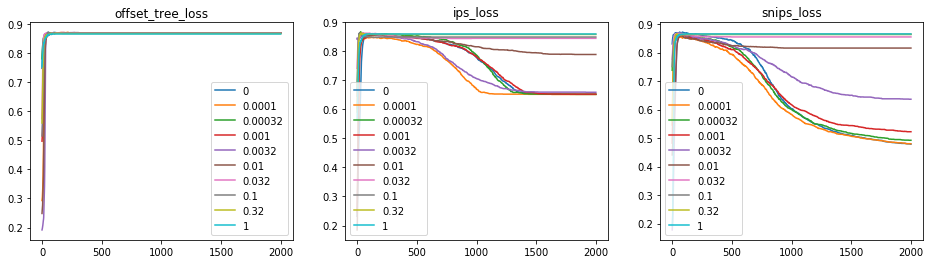

In [358]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))

for l, ax in zip(['offset_tree_loss', 'ips_loss', 'snips_loss'], axes): 
    plt.sca(ax)
    for r in [r for r in result if r['loss'] == l]:
        plt.plot(r['history']['epoch'], r['history']['metrics', 'true_reward'], label=repr(r['decay']))
    
    plt.title(l)
    plt.legend(loc='best')

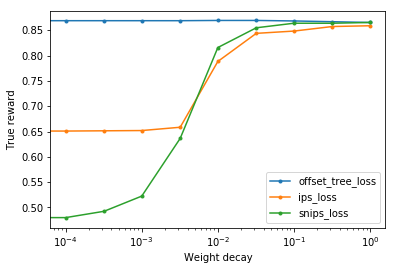

In [359]:
for l in 'offset_tree_loss', 'ips_loss', 'snips_loss':
    subset = [r for r in result if r['loss'] == l] 
    plt.plot(
        [r['decay'] for r in subset], 
        [r['history']['metrics', 'true_reward'][-1] for r in subset],
        '.-',
        label=l,
    )
plt.xscale('log')
plt.xlabel('Weight decay')
plt.ylabel('True reward')
plt.legend(loc='best')

In [389]:
from chmp.ds import  mpl_set

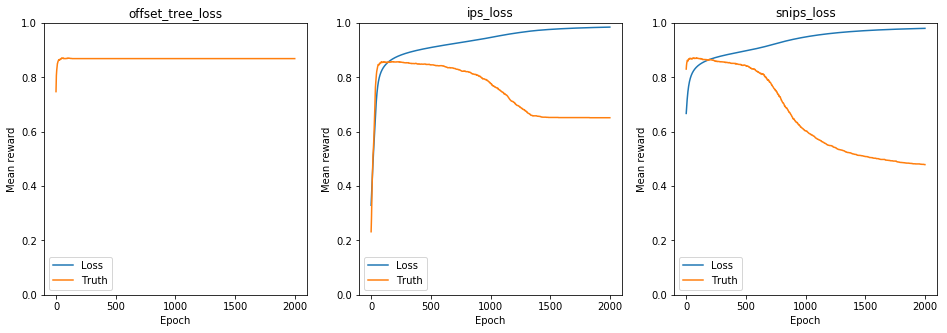

In [390]:
c0, c1 = get_color_cycle(2)

_, axes = plt.subplots(1, 3, figsize=(16, 5))
for l, ax in zip(['offset_tree_loss', 'ips_loss', 'snips_loss'], axes): 
    plt.sca(ax)
    example, *_ = [r for r in result if r['loss'] == l]
    plt.plot(
        example['history']['epoch'], 
        -np.asarray(example['history']['loss']), 
        label='Loss', 
        color=c0,
    )
    plt.plot(
        example['history']['epoch'], 
        np.asarray(example['history']['metrics', 'true_reward']), 
        label='Truth', 
        color=c1,
    )
    mpl_set(
        xlabel='Epoch',
        ylabel='Mean reward',
        legend=True,
        ylim=(0, 1),
        title=l,
    )

# Todo

- use test set
- shifted rewards
- Lagrange multiplier ...
- More complex reward model ...
- Unblanced data set

https://portal.ds.microsoft.com/